[bağlantı metni](https://)

## **Importing Libraries**

In [4]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Visualizing Single Audio**

In [2]:
dataSetPath = '/content/drive/MyDrive/Music Genre Classification/Data'
audioName = dataSetPath + '/blues.00000.wav'

print(os.listdir(dataSetPath))

['features_30_sec.csv', 'features_3_sec.csv', 'images_original', 'genres_original', 'blues.00000.wav', 'Test Data', 'Test Data 2']


In [ ]:
y,sr = librosa.load(audioName, sr = 44100)
plt.figure(figsize = (14,5))
librosa.display.waveshow(y, sr = sr)

NameError: name 'librosa' is not defined

## **Playing Audio**

In [ ]:
from IPython.display import Audio
Audio(data = y, rate = sr)

Output hidden; open in https://colab.research.google.com to view.

### **Visualization on Chunks of Audio**

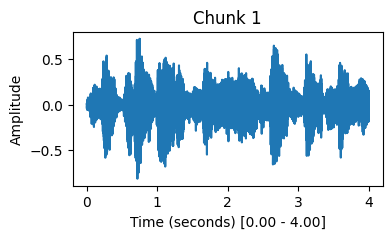

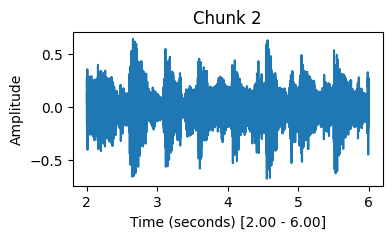

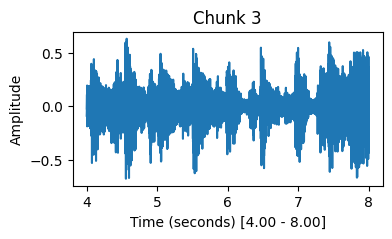

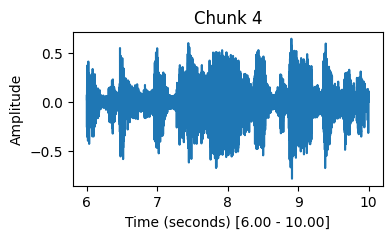

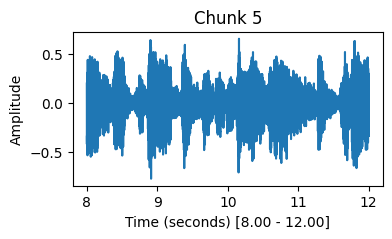

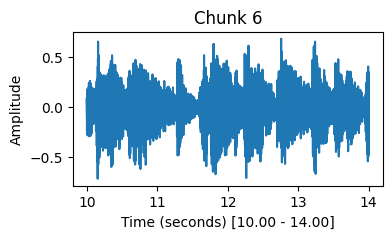

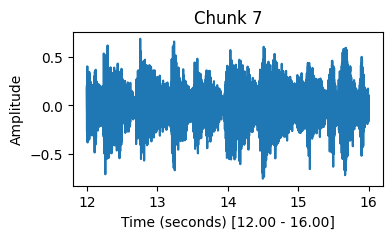

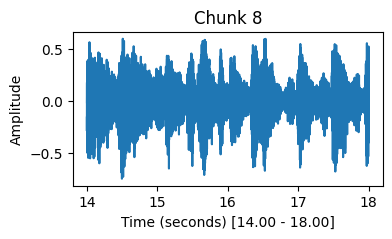

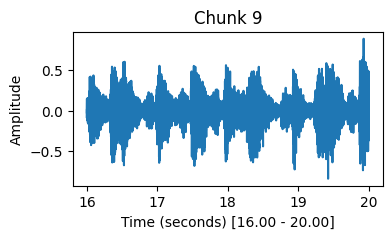

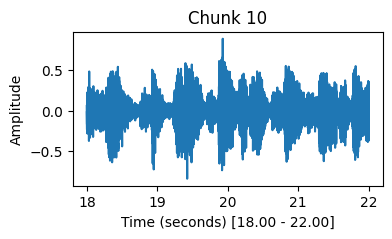

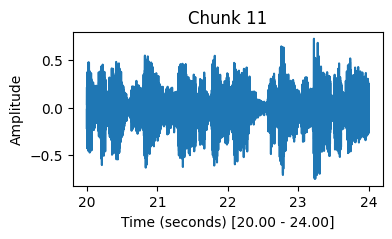

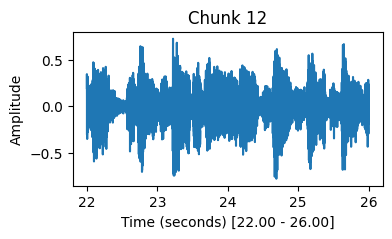

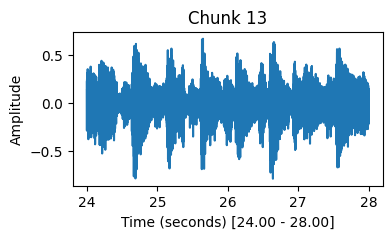

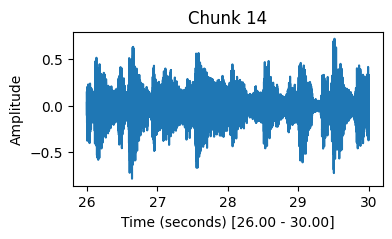

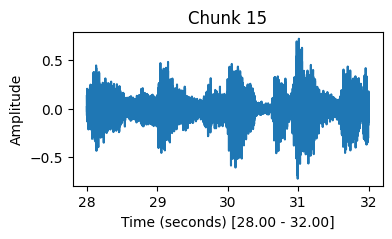

In [ ]:
dataSetPath = '/content/drive/MyDrive/Music Genre Classification/Data'
audioName = dataSetPath + '/blues.00000.wav'
y,sr = librosa.load(audioName, sr = None) # sr = None deme sebebimiz, orjinal 'sample rate' değerini korumak istememiz.

chunkDuration = 4
overlapDuration = 2

# Convert duration to sample
chunkSamples = chunkDuration * sr
overlapSamples = overlapDuration * sr

# Chunk number calculation
numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

# Iterate over each chunks
for i in range(numChunks):
    start = i * (chunkSamples - overlapSamples)
    end = start + chunkSamples
    chunk = y[start:end]

    start_time_sec = start / sr
    end_time_sec = end / sr

    time_axis = np.linspace(start_time_sec, end_time_sec, len(chunk))

    plt.figure(figsize=(4, 2))
    plt.plot(time_axis, chunk)
    plt.xlabel(f'Time (seconds) [{start_time_sec:.2f} - {end_time_sec:.2f}]')
    plt.ylabel('Amplitude')
    plt.title(f'Chunk {i+1}')
    plt.show()

## **Single Audio Melspectrogram Visualization**

In [ ]:
def plotMelspectrogram(y, sr):
  # Compute spectogram
  spectogram = librosa.feature.melspectrogram(y = y, sr = sr)
  # Conver to decibel
  spectogramDb = librosa.power_to_db(spectogram, ref = np.max)
  # Visualize the spectogram
  plt.figure(figsize = (10, 4))
  librosa.display.specshow(spectogramDb, sr = sr, x_axis = 'time', y_axis = 'mel')
  plt.colorbar(format = '%2.0f dB')
  plt.title("Spectogram")
  plt.tight_layout()
  plt.show()

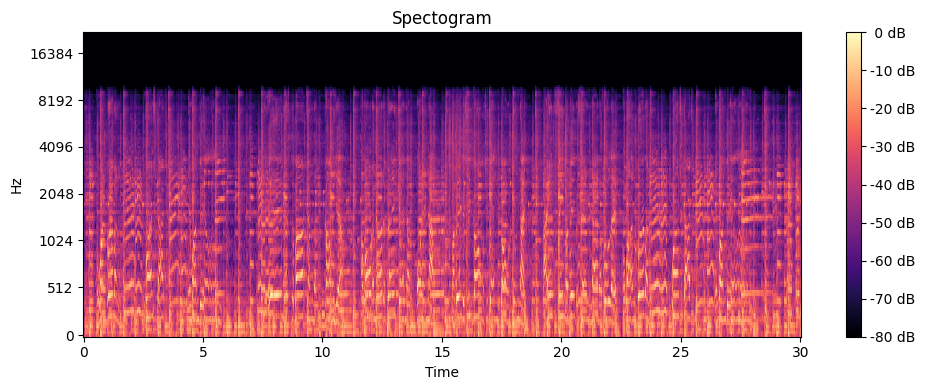

In [ ]:
dataSetPath = '/content/drive/MyDrive/Music Genre Classification/Data'
audioName = dataSetPath + '/blues.00000.wav'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogram(y, sr)

## **Chunk's Melspectrogram Visualization**

In [3]:
def plotMelspectrogramChunks(y, sr):
    chunkDuration = 4  # Each chunk duration in seconds
    overlapDuration = 2  # Overlap between chunks in seconds

    # Convert duration to samples
    chunkSamples = chunkDuration * sr
    overlapSamples = overlapDuration * sr

    # Calculate the number of chunks
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    # Iterate over each chunk
    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        # Calculate time offset for each chunk
        start_time_sec = start / sr
        end_time_sec = end / sr

        # Plot Mel Spectrogram of the chunk
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis=None, y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title(f'Chunk {i+1} Mel Spectrogram ({start_time_sec:.2f} - {end_time_sec:.2f} seconds)')

        # Set custom time ticks
        num_ticks = 5
        time_ticks = np.linspace(0, spectrogram_db.shape[1], num_ticks)
        time_labels = np.linspace(start_time_sec, end_time_sec, num_ticks)
        plt.xticks(time_ticks, [f'{t:.2f}' for t in time_labels])

        plt.xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()


In [ ]:
dataSetPath = '/content/drive/MyDrive/Music Genre Classification/Data'
audioName = dataSetPath + '/blues.00000.wav'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogramChunks(y = y, sr = sr)

Output hidden; open in https://colab.research.google.com to view.

## **All Data Set Melspectrogram**

In [21]:
dataSetPath = '/content/drive/MyDrive/Music Genre Classification/Data/genres_original'
classes = ['rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical', 'blues']

In [5]:
def MelspectrogramChunks(y, sr, targetShape, data, labels, iClass):
    chunkDuration = 4  # Each chunk duration in seconds
    overlapDuration = 2  # Overlap between chunks in seconds

    # Convert duration to samples
    chunkSamples = chunkDuration * sr
    overlapSamples = overlapDuration * sr

    # Calculate the number of chunks
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    # Iterate over each chunk
    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        # Calculate time offset for each chunk
        start_time_sec = start / sr
        end_time_sec = end / sr

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)

        resizedSpectrogram = resize(np.expand_dims(spectrogram, axis = -1), targetShape)

        data.append(resizedSpectrogram)
        labels.append(iClass)

In [6]:
def loadAndPreprocessData(dataDir, classes, targetShape = (150, 150)):
  data = []
  labels = []

  for iClass, className in enumerate(classes):
    classDir = os.path.join(dataDir, className)
    print("Processing: ", className)
    for fileName in os.listdir(classDir):
      if fileName.endswith('.wav'):
        filePath = os.path.join(classDir, fileName)
        try:
          audioData, sampleRate = librosa.load(filePath, sr=None)
          MelspectrogramChunks(audioData, sampleRate, targetShape, data, labels, iClass)
        except Exception as e:
          print(f"Hata oluştu: {filePath} dosyası atlandı. Hata: {e}")
  return np.array(data), np.array(labels)

In [7]:
data, labels = loadAndPreprocessData(dataSetPath, classes)

Processing:  rock
Processing:  reggae
Processing:  pop
Processing:  metal
Processing:  jazz


<ipython-input-6-fdde7314e89b>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audioData, sampleRate = librosa.load(filePath, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Hata oluştu: /content/drive/MyDrive/Music Genre Classification/Data/genres_original/jazz/jazz.00054.wav dosyası atlandı. Hata: 
Processing:  hiphop
Processing:  disco
Processing:  country
Processing:  classical
Processing:  blues


In [8]:
labels = to_categorical(labels, num_classes = len(classes)) # Converting labels, one-hot encoding

In [9]:
np.save('/content/drive/My Drive/Music Genre Classification/Models/data.npy', data)
np.save('/content/drive/My Drive/Music Genre Classification/Models/labels.npy', labels)

## **Splitting Dataset into Training and Test Set**

In [8]:
from sklearn.model_selection import train_test_split

XTrain, XTest, YTrain, YTest = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [9]:
np.save('/content/drive/My Drive/Music Genre Classification/Models/XTrain.npy', XTrain)
np.save('/content/drive/My Drive/Music Genre Classification/Models/YTrain.npy', YTrain)
np.save('/content/drive/My Drive/Music Genre Classification/Models/XTest.npy', XTest)
np.save('/content/drive/My Drive/Music Genre Classification/Models/YTest.npy', YTest)

In [12]:
XTrain[0].shape

(150, 150, 1)

## **Building Model**

In [5]:
model = tf.keras.models.Sequential()

Sequential Model: Katmanların sırayla birbirine eklendiği basit bir yapıdır. Görüntü işleme için yaygın olarak kullanılır.

In [10]:
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = XTrain[0].shape))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'):

  * 32 Filtre: Görüntüdeki temel özellikleri (kenar, köşe) yakalar.

  * Kernel Size (3x3): 3x3 boyutlu filtreler kullanılır.

  * Padding='same': Çıktı boyutu, giriş boyutuyla aynı tutulur.

  * Activation='relu': Negatif değerleri sıfırlayarak doğrusal olmayan özellik
  çıkarımı sağlar.

  * input_shape=(210,210,1): Giriş görüntüsünün boyutu (210x210 piksel, 1 kanal gri tonlamalı).

MaxPooling2D(pool_size=(2, 2), strides=2):

  * Havuzlama (Pooling): Boyutları yarıya indirir, hesaplama yükünü azaltır.

In [11]:
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

In [12]:
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

In [13]:
model.add(Dropout(0.3))

* **Dropout**, bir düzenleme (regularization) tekniğidir ve özellikle aşırı öğrenmeyi (overfitting) önlemek için kullanılır. Modelin eğitim sırasında bazı nöronları rastgele devre dışı bırakmasını sağlar. Bu, modelin veri üzerindeki genelleme yeteneğini artırır ve yalnızca eğitim verisine aşırı bağımlı hale gelmesini engeller.

* **0.3**:
Bu, %30 oranında nöronun her eğitim adımında rastgele devre dışı bırakılacağını (yani kullanılmayacağını) belirtir. Geriye kalan %70 nöron ile öğrenme gerçekleşir.

In [14]:
model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

In [15]:
model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

In [16]:
model.add(Dropout(0.3))

In [17]:
model.add(Flatten())

* Flatten: Konvolüsyon katmanlarından çıkan çok boyutlu veriyi tek boyutlu hale getirir. Bu adım, veriyi tam bağlantılı (Dense) katmanlara hazırlamak içindir.


In [18]:
model.add(Dense(units = 1200, activation = 'relu'))

* **Dense (Tam Bağlantılı Katman)**, yapay sinir ağlarında en yaygın kullanılan katman türlerinden biridir. Bu katman, tüm giriş nöronlarını çıkış nöronlarına bağlar ve her bir nöronun diğer tüm nöronlarla etkileşime girmesini sağlar.

* **units=1200**:
Bu katmanda 1200 adet nöron bulunur. Her bir nöron, bir ağırlık (w) ve bias (b) değeriyle çalışır.
Giriş verisinin her bir özelliği bu 1200 nöron ile bağlantılıdır.
Bu nöronlar, bir sonraki katmana özellik çıkarımı sağlar.


In [19]:
model.add(Dropout(0.45))

In [23]:
model.add(Dense(units = len(classes), activation = 'softmax'))

* Dense(10, activation='softmax'): Çıkış katmanı. 10 sınıf için olasılık tahmini yapar. Softmax, toplamı 1 olan olasılıklar döndürür ve en yüksek olasılıkta olan sınıfı seçer.

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 210, 210, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 210, 210, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 105, 105, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 105, 105, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 103, 103, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 51, 51, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 22, 22, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1200)                │       9,831,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,555,258 (55.52 MB)

 Trainable params: 14,555,258 (55.52 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile the Model**

In [24]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### **Training the Model**

In [25]:
trainingHistory = model.fit(XTrain, YTrain, batch_size = 32, epochs = 15, validation_data = (XTest, YTest))

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.1958 - loss: 2.1544 - val_accuracy: 0.4387 - val_loss: 1.5845
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.4626 - loss: 1.5147 - val_accuracy: 0.5970 - val_loss: 1.1604
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.5861 - loss: 1.1845 - val_accuracy: 0.6174 - val_loss: 1.1027
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6556 - loss: 0.9955 - val_accuracy: 0.6998 - val_loss: 0.8860
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.7088 - loss: 0.8426 - val_accuracy: 0.7399 - val_loss: 0.7750
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.7544 - loss: 0.7164 - val_accuracy: 0.7563 - val_loss: 0.7546
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.7847 - loss: 0.6412 - val_accuracy: 0.7937 - val_loss: 0.6151
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8246 - loss: 0.5263 - 

In [ ]:
trainingHistory.history

{'accuracy': [0.2929048538208008,
  0.5264607667922974,
  0.6281301975250244,
  0.7048413753509521,
  0.7505843043327332,
  0.7962437272071838,
  0.8287145495414734,
  0.8620200157165527,
  0.8820534348487854,
  0.9015859961509705,
  0.920450747013092,
  0.9280467629432678,
  0.9378130435943604,
  0.9520033597946167,
  0.9585142135620117,
  0.9611018300056458,
  0.9662771224975586,
  0.9651919603347778,
  0.9700334072113037,
  0.9736226797103882,
  0.9797996878623962,
  0.9805509448051453,
  0.9805509448051453,
  0.9830551147460938,
  0.9811352491378784,
  0.982721209526062,
  0.9830551147460938,
  0.988480806350708,
  0.9843071699142456,
  0.9896494150161743],
 'loss': [1.919510006904602,
  1.3457213640213013,
  1.0723017454147339,
  0.8735954165458679,
  0.7362963557243347,
  0.6081023216247559,
  0.5050767660140991,
  0.4188588559627533,
  0.3535900413990021,
  0.2921507954597473,
  0.2334945648908615,
  0.21881268918514252,
  0.18183521926403046,
  0.146326944231987,
  0.1209815666

In [7]:
data = np.load('/content/drive/My Drive/Music Genre Classification/Models/data.npy')
labels = np.load('/content/drive/My Drive/Music Genre Classification/Models/labels.npy')

In [ ]:
XTrain = np.load('/content/drive/My Drive/Music Genre Classification/Models/XTrain.npy')
YTrain = np.load('/content/drive/My Drive/Music Genre Classification/Models/YTrain.npy')
XTest = np.load('/content/drive/My Drive/Music Genre Classification/Models/XTest.npy')
YTest = np.load('/content/drive/My Drive/Music Genre Classification/Models/YTest.npy')

In [32]:
model.save('/content/drive/My Drive/Music Genre Classification/Models/Trained_model.keras')

In [39]:
import json
with open('/content/drive/My Drive/Music Genre Classification/Models/trainingHistory.json', 'w') as f:
    json.dump(trainingHistory.history, f)

In [33]:
from tensorflow.keras.models import load_model
loadedModel = load_model('/content/drive/My Drive/Music Genre Classification/Models/Trained_model.keras')

In [40]:
import json

with open('/content/drive/My Drive/Music Genre Classification/Models/trainingHistory.json', 'r') as f:
    trainingHistoryData = json.load(f)

In [ ]:
trainingHistoryData.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
trainingHistoryData

{'accuracy': [0.31035059690475464,
  0.533806324005127,
  0.6367278695106506,
  0.7038397192955017,
  0.7611852884292603,
  0.8020868301391602,
  0.8442404270172119,
  0.8691151738166809,
  0.8904006481170654,
  0.9078463912010193,
  0.9242904782295227,
  0.9436560869216919,
  0.9441569447517395,
  0.9567612409591675,
  0.95350581407547,
  0.96652752161026,
  0.9686978459358215,
  0.9778798222541809,
  0.9649415612220764,
  0.9803004860877991,
  0.9785475730895996,
  0.9751251935958862,
  0.9839732646942139,
  0.9823873043060303,
  0.9853923320770264,
  0.9814690947532654,
  0.9825542569160461,
  0.9883138537406921,
  0.9830551147460938,
  0.9914023280143738],
 'loss': [1.8943103551864624,
  1.33579421043396,
  1.0573639869689941,
  0.8556206226348877,
  0.7051504850387573,
  0.5798492431640625,
  0.4585910141468048,
  0.3769867420196533,
  0.32704684138298035,
  0.26937422156333923,
  0.22535333037376404,
  0.17675547301769257,
  0.16720330715179443,
  0.1302214115858078,
  0.13785018

## **Model Evaluation**

In [34]:
trainLoss, trainAccuracy = loadedModel.evaluate(XTrain, YTrain)

375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9759 - loss: 0.0859


In [35]:
vallLoss, vallAccuracy = loadedModel.evaluate(XTest, YTest)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8729 - loss: 0.4278


In [ ]:
print(trainLoss, trainAccuracy, vallLoss, vallAccuracy)

0.008066887967288494 0.9976627826690674 0.35219794511795044 0.918196976184845


### **Accuracy & Loss Visualization**

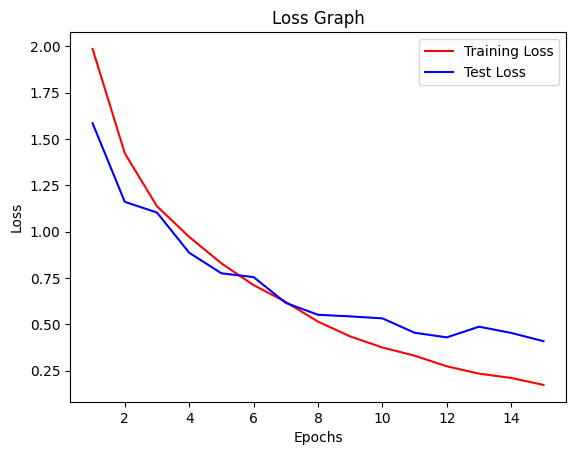

In [42]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, trainingHistoryData['loss'], label = "Training Loss", color = 'red')
plt.plot(epochs, trainingHistoryData['val_loss'], label = "Test Loss", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

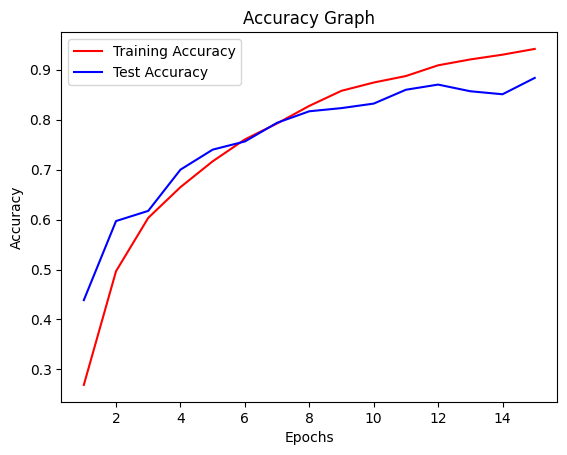

In [43]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, trainingHistoryData['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, trainingHistoryData['val_accuracy'], label = "Test Accuracy", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

## **Confusion Matrix Bileşenleri**

* True Positive (TP): Modelin, olumlu bir örneği doğru bir şekilde olumlu olarak sınıflandırdığı durum.
* True Negative (TN): Modelin, olumsuz bir örneği doğru bir şekilde olumsuz olarak sınıflandırdığı durum.
* False Positive (FP): Modelin, olumsuz bir örneği yanlışlıkla olumlu olarak sınıflandırdığı durum. (Tip I Hatası)
* False Negative (FN): Modelin, olumlu bir örneği yanlışlıkla olumsuz olarak sınıflandırdığı durum. (Tip II Hatası)


### **Metrikler**

**Precision (Kesinlik)**
$$Precision = \frac{\sum TP}{\sum TP + \sum FP}$$
* Modelin olumlu tahminlerinin ne kadar doğru olduğunu gösterir.
* Örneğin: Spam e-posta tespiti yaparken, gerçekten spam olanların oranı.

**Recall (Duyarlılık)**
$$Recall = \frac{\sum TP}{\sum TP + \sum FN}$$
* Gerçek olumlu örneklerin ne kadarını doğru tahmin ettiğini gösterir.
* Örneğin: Kanser teşhisi yapan bir modelde, gerçekten kanserli olanların ne kadarını yakalayabildiği.

**Accuracy (Doğruluk)**
$$Accuracy = \frac{\sum TP + \sum TN}{\sum TP + \sum FP + \sum FN + \sum TN}$$
* Modelin tüm tahminlerindeki genel doğruluk oranını gösterir.
* Ancak dengesiz veri setlerinde yanıltıcı olabilir. (Örneğin, nadir hastalık tespiti gibi.)


In [ ]:
XTest.shape

(2995, 210, 210, 1)

In [ ]:
YTest.shape

(2995, 10)

In [44]:
YPred = loadedModel.predict(XTest)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [45]:
YPred.shape

(2995, 10)

In [46]:
predictedCategories = np.argmax(YPred, axis = 1)
predictedCategories

array([7, 6, 6, ..., 0, 1, 4])

In [47]:
trueCategories = np.argmax(YTest, axis = 1)
trueCategories

array([7, 6, 6, ..., 0, 1, 4])

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(trueCategories, predictedCategories)

print(classification_report(trueCategories, predictedCategories, target_names = classes))

              precision    recall  f1-score   support

        rock       0.74      0.84      0.79       301
      reggae       0.91      0.93      0.92       299
         pop       0.85      0.90      0.87       317
       metal       0.97      0.91      0.94       312
        jazz       0.92      0.86      0.89       277
      hiphop       0.96      0.88      0.92       313
       disco       0.89      0.91      0.90       301
     country       0.84      0.77      0.81       288
   classical       0.92      0.96      0.94       296
       blues       0.87      0.86      0.87       291

    accuracy                           0.88      2995
   macro avg       0.89      0.88      0.88      2995
weighted avg       0.89      0.88      0.88      2995



In [52]:
import json

results = {
    "precision": 0.92,
    "recall": 0.92,
    "f1-score": 0.92,
    "accuracy": 0.92,
    "class_metrics": {
        "rock": {"precision": 0.85, "recall": 0.86, "f1-score": 0.85},
        "reggae": {"precision": 0.97, "recall": 0.88, "f1-score": 0.92},
        "pop": {"precision": 0.93, "recall": 0.93, "f1-score": 0.93},
        "metal": {"precision": 0.96, "recall": 0.95, "f1-score": 0.96},
        "jazz": {"precision": 0.88, "recall": 0.96, "f1-score": 0.92},
        "hiphop": {"precision": 0.89, "recall": 0.86, "f1-score": 0.88},
        "disco": {"precision": 0.88, "recall": 0.94, "f1-score": 0.91},
        "country": {"precision": 0.88, "recall": 0.89, "f1-score": 0.88},
        "classical": {"precision": 0.96, "recall": 0.95, "f1-score": 0.95},
        "blues": {"precision": 0.98, "recall": 0.87, "f1-score": 0.92}
    }
}

with open('/content/drive/My Drive/Music Genre Classification/Models/metrics.json', 'w') as f:
    json.dump(results, f, indent=4)

In [51]:
import json

with open('/content/drive/My Drive/Music Genre Classification/Models/metrics.json', 'r') as f:
    metrics = json.load(f)

print(metrics)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Music Genre Classification/Models/metrics.json'

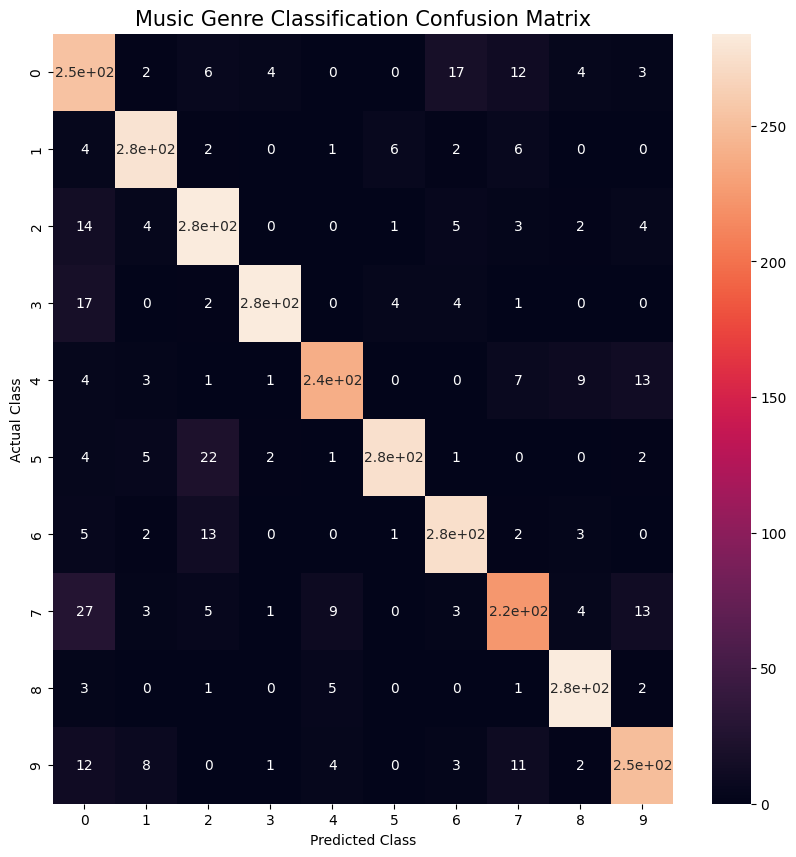

In [50]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()